In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### 독립변수는 petal_length 컬럼, 종속변수는 petal_width 컬럼으로 해보자.

### (1) DataFrame 생성

In [20]:
file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [22]:
iris = iris[['petal_length', 'petal_width']]
iris

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


### (2) 회귀선 그래프

In [53]:
train, test = train_test_split(iris, train_size=0.6)

In [54]:
xtrain = train.drop(['petal_width'],axis=1)
ytrain = train['petal_width']
xtest = test.drop(['petal_width'],axis=1)
ytest = test['petal_width']

In [55]:
regression = linear_model.LinearRegression()
model = regression.fit(xtrain, ytrain)

In [56]:
model.coef_

array([0.41915674])

In [57]:
model.intercept_

-0.35864497979283994

#### x train에 대한 회귀선 그래프

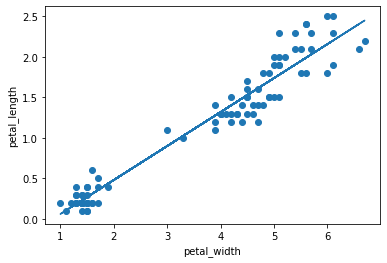

In [81]:
%matplotlib inline

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xtrain,ytrain)
ax.set_ylabel('petal_length') 
ax.set_xlabel('petal_width')
ax.plot(xtrain,xtrain*model.coef_+model.intercept_)

#### y test에 대한 회귀선 그래프

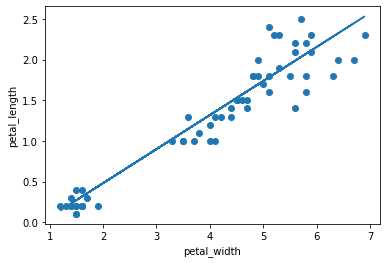

In [82]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xtest,ytest)
ax.set_ylabel('petal_length') 
ax.set_xlabel('petal_width')
ax.plot(xtest,xtest*model.coef_+model.intercept_)

### 3) Spark를 사용하여 회귀분석하고 계수 출력

In [35]:
import pyspark
import os

os.environ["PYSPARK_PYTHON"]='C:\\Users\\201910810\\Anaconda3\\python.exe'
os.environ["PYSPARK_DRIVER_PYTHON"]='C:\\Users\\201910810\\Anaconda3\\python.exe'

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [48]:
sparkDf=spark.createDataFrame(iris)

In [49]:
(trainDf, testDf) = sparkDf.randomSplit([0.6, 0.4])

In [90]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ['petal_length'],
                                   outputCol = 'features')

In [91]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [92]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[va, lr])

In [93]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [94]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.2629788970820525]
Intercept: 0.233


### (4) 실제와 예측 출력

In [66]:
ypred = regression.predict(xtest)

In [67]:
y_actual_pred = pd.DataFrame({'Actual': ytest, 'Predicted': ypred})

In [70]:
y_actual_pred.head(5)

,Actual,Predicted
81,1.0,1.192235
86,1.5,1.611392
11,0.2,0.312006
25,0.2,0.312006
123,1.8,1.695223


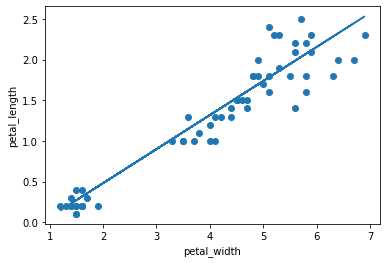

In [83]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xtest,ytest)
ax.set_ylabel('petal_length') 
ax.set_xlabel('petal_width')
ax.plot(xtest,ypred)

### (4) 정확성 평가하고 출력

#### 모델에 대한 정확성

In [79]:
accuracy = regression.score(xtest,ytest)
f"accuracy: {accuracy*100:.2f}%"

'accuracy: 90.14%'

#### MSE

In [84]:
print("Mean Squared Error: %.2f" % np.mean((regression.predict(xtest) - ytest) ** 2))

Mean Squared Error: 0.05


#### $R^2$

In [85]:
from sklearn.metrics import r2_score

r2 = r2_score(ytest, ypred )
f"r2: {r2:.3f}"

'r2: 0.901'